In [129]:
import pandas as pd
from rdkit import Chem

def prepare_data():
    df_main = pd.read_csv(r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\init_data\pKa_Prediction_Starting data_2024.01.25.csv', index_col=0)
    df_main = pd.read_csv(r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\init_data\pKa_Prediction_Starting data_2024.05.07.csv', index_col=0)

    SMILES_to_fgroup = {}
    SMILES_to_identificator = {}
    SMILES_to_cycle_type = {}
    SMILES_to_pKa = {}
    for index, row in df_main.iterrows():
        SMILES = row['Smiles']
        if pd.isnull(SMILES):
            continue
        
        SMILES_to_fgroup[SMILES] = row['F group']
        SMILES_to_identificator[SMILES] = row['identificator']
        SMILES_to_cycle_type[SMILES] = row['Framework']
        SMILES_to_pKa[SMILES] = row['pKa']
    
    return SMILES_to_fgroup, SMILES_to_identificator, SMILES_to_cycle_type, SMILES_to_pKa

def train_test_smiles_data(is_canon=True):
    train = pd.read_csv(r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\pKa_basicity_data\gnn_cv_canon_smiles\train_basic.csv')
    test = pd.read_csv(r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\pKa_basicity_data\gnn_cv_canon_smiles\test_basic.csv')

    train_SMILES = train['Smiles'].tolist()
    test_SMILES = test['Smiles'].tolist()

    smiles_to_fold = {}
    for index, row in train.iterrows():
        smiles_to_fold[row['Smiles']] = row['fold_id']

    if is_canon:
        for train_index in range(len(train_SMILES)):
            train_SMILES[train_index] = Chem.CanonSmiles(train_SMILES[train_index])
        for test_index in range(len(test_SMILES)):
            test_SMILES[test_index] = Chem.CanonSmiles(test_SMILES[test_index])
    
    return train_SMILES, test_SMILES, smiles_to_fold

train_SMILES, test_SMILES, smiles_to_fold = train_test_smiles_data()

In [130]:
from rdkit import Chem
import re

def convert_google_sheet_url(url):
    pattern = r'https://docs\.google\.com/spreadsheets/d/([a-zA-Z0-9-_]+)(/edit#gid=(\d+)|/edit.*)?'

    replacement = lambda m: f'https://docs.google.com/spreadsheets/d/{m.group(1)}/export?' + (f'gid={m.group(3)}&' if m.group(3) else '') + 'format=csv'

    new_url = re.sub(pattern, replacement, url)

    return new_url

import pandas as pd

url = 'https://docs.google.com/spreadsheets/d/1CzpQGGeGzVZ0sv-pUm6jfaQ2dB6vecDpXeotMhIpUnQ/edit#gid=0'

new_url = convert_google_sheet_url(url)

print(new_url)

df = pd.read_csv(new_url)

df.dropna(subset=['F Group'], inplace=True)

smiles_to_id = {}
for index, row in df.iterrows():
    smiles_to_id[Chem.CanonSmiles(row['Amine/Acid SMILES'])] = row['Amide ID']

https://docs.google.com/spreadsheets/d/1CzpQGGeGzVZ0sv-pUm6jfaQ2dB6vecDpXeotMhIpUnQ/export?gid=0&format=csv


In [131]:
SMILES_to_fgroup, SMILES_to_identificator, SMILES_to_cycle_type, SMILES_to_pKa = prepare_data()
train_smiles, test_smiles, smiles_to_fold = train_test_smiles_data()

In [132]:
# SME_fluorine_secondary = {'FC(F)(F)C12CC(C1)CN2C(=O)C1=CC=CC=C1': 0.187, 'FC(F)(F)C1CCCN1C(=O)C1=CC=CC=C1': 0.368, 'O=C(N1CC2CC1C2)C1=CC=CC=C1': -0.13910609483718872, 'O=C(N1CCCC1)C1=CC=CC=C1': -0.0785289853811264, 'CC12CC(C1)CN2C(=O)C1=CC=CC=C1': -0.09564696997404099, 'FC(F)(F)C12CCC(CN1C(=O)C1=CC=CC=C1)C2': 0.267, 'FC(F)(F)C12CCC(CC1)CN2C(=O)C1=CC=CC=C1': 0.175, 'FC(F)(F)C1CCCCN1C(=O)C1=CC=CC=C1': 0.455, 'O=C(N1CC2CCC1C2)C1=CC=CC=C1': -0.17767366766929626, 'CC12CCC(CC1)CN2C(=O)C1=CC=CC=C1': -0.24370118975639343, 'O=C(N1CC2CCC1CC2)C1=CC=CC=C1': 0.4168475270271301, 'O=C(N1CCCCC1)C1=CC=CC=C1': -0.24286195635795593, 'FC(F)(F)C12CC(CN1C(=O)C1=CC=CC=C1)CCC2': 0.244, 'O=C(N1CC2CC1CCC2)C1=CC=CC=C1': -0.5416865944862366, 'CC12CC(CN1C(=O)C1=CC=CC=C1)CCC2': 0.563825786113739, 'FC1(F)CC2CC(CN(C2)C(=O)C2=CC=CC=C2)C1': 0.05, 'FC1(F)CC2CN(CC(C1)C2(F)F)C(=O)C1=CC=CC=C1': -0.056, 'FC1(F)C2CCCC1CN(C2)C(=O)C1=CC=CC=C1': 0.214, 'FC1(F)C2COCC1CN(C2)C(=O)C1=CC=CC=C1': -0.203, 'O=C(N1CC2COCC(C2)C1)C1=CC=CC=C1': -0.8497052192687988, 'FC1(F)C2CCC1CN(C2)C(=O)C1=CC=CC=C1': 0.071, 'O=C(N1CC2CCC(C2)C1)C1=CC=CC=C1': -0.07352640479803085, 'O=C(N1CCC1)C1=CC=CC=C1': -0.21231365203857422, 'FC1CN(C1)C(=O)C1=CC=CC=C1': -0.203, 'FC1CCN(C1)C(=O)C1=CC=CC=C1': -0.282, 'FC1(F)CCN(C1)C(=O)C1=CC=CC=C1': -0.022, 'F[C@H]1CN(C[C@H]1F)C(=O)C1=CC=CC=C1': -0.134, 'F[C@@H]1CN(C[C@H]1F)C(=O)C1=CC=CC=C1': -0.219, 'FC1CCCN(C1)C(=O)C1=CC=CC=C1': -0.018, 'FC1(F)CCCN(C1)C(=O)C1=CC=CC=C1': -0.043, 'F[C@H]1C[C@@H](F)CN(C1)C(=O)C1=CC=CC=C1': -0.024, 'F[C@H]1C[C@H](F)CN(C1)C(=O)C1=CC=CC=C1': -0.012, 'F[C@@H]1CCN(C[C@@H]1F)C(=O)C1=CC=CC=C1': -0.136, 'F[C@@H]1CCN(C[C@H]1F)C(=O)C1=CC=CC=C1': -0.05, '[H]C(F)(F)C1CCCCN1C(=O)C1=CC=CC=C1': -0.047, '[H]C([H])(F)C1CCCCN1C(=O)C1=CC=CC=C1': 0.087, '[H]C(F)(F)C1CCCN1C(=O)C1=CC=CC=C1': 0.107, '[H]C([H])(F)C1CCCN1C(=O)C1=CC=CC=C1': 0.075, 'FC(F)(F)C1CCN1C(=O)C1=CC=CC=C1': 0.349, '[H]C(F)(F)C1CCN1C(=O)C1=CC=CC=C1': 0.035, '[H]C([H])(F)C1CCN1C(=O)C1=CC=CC=C1': -0.098, 'FC(F)(F)C1CCCN(C1)C(=O)C1=CC=CC=C1': 0.383, '[H]C(F)(F)C1CCCN(C1)C(=O)C1=CC=CC=C1': -0.059, '[H]C([H])(F)C1CCCN(C1)C(=O)C1=CC=CC=C1': -0.046, 'FC(F)(F)C1CCN(C1)C(=O)C1=CC=CC=C1': 0.104, '[H]C(F)(F)C1CCN(C1)C(=O)C1=CC=CC=C1': 0.07, 'FC(F)(F)C1CN(C1)C(=O)C1=CC=CC=C1': 0.296, '[H]C(F)(F)C1CN(C1)C(=O)C1=CC=CC=C1': 0.118, '[H]C([H])(F)C1CN(C1)C(=O)C1=CC=CC=C1': -0.167, 'FC(F)(F)C1CCN(CC1)C(=O)C1=CC=CC=C1': 0.135, '[H]C([H])(F)C1CCN(CC1)C(=O)C1=CC=CC=C1': -0.069, 'FC1CCN(CC1)C(=O)C1=CC=CC=C1': -0.233, 'O=C(N1CC2CCCC(C2)C1)C1=CC=CC=C1': 0.6178117394447327, 'FC1(F)CCN(CC1)C(=O)C1=CC=CC=C1': 0.093, '[H]C(F)(F)C1CCN(CC1)C(=O)C1=CC=CC=C1': -0.037, '[H]C([H])(F)C1CCN(C1)C(=O)C1=CC=CC=C1': -0.177, 'FC1(F)CN(C1)C(=O)C1=CC=CC=C1': -0.096}
# SME_fluorine_primary = {'FC1(F)[C@H]2C[C@H](C[C@@H]12)NC(=O)C1=CC=CC=C1': 0.102, 'FC1(F)CCC(CC1)NC(=O)C1=CC=CC=C1': 0.148, 'O=C(NC1CCCCC1)C1=CC=CC=C1': 0.5560212731361389, 'O=C(N[C@@H]1C[C@@H]2C[C@@H]2C1)C1=CC=CC=C1': 0.10438874363899231, 'O=C(N[C@H]1C[C@@H]2C[C@@H]2C1)C1=CC=CC=C1': 0.07871818542480469, 'FC(F)(F)C1(CCC1)NC(=O)C1=CC=CC=C1': 0.084, 'FCC1(CCC1)NC(=O)C1=CC=CC=C1': 0.102, 'FC(F)(F)[C@H]1C[C@@H](C1)NC(=O)C1=CC=CC=C1': 0.48, 'FC(F)(F)[C@@H]1C[C@@H](C1)NC(=O)C1=CC=CC=C1': 0.204, '[H]C(F)(F)[C@H]1C[C@@H](C1)NC(=O)C1=CC=CC=C1': 0.077, '[H]C(F)(F)[C@@H]1C[C@@H](C1)NC(=O)C1=CC=CC=C1': 0.152, '[H]C([H])(F)[C@H]1C[C@@H](C1)NC(=O)C1=CC=CC=C1': -0.139, '[H]C([H])(F)[C@@H]1C[C@@H](C1)NC(=O)C1=CC=CC=C1': -0.065, '[H]C(F)(F)CNC(=O)C1=CC=CC=C1': -0.169, '[H]C(F)(F)CCNC(=O)C1=CC=CC=C1': 0.148, '[H]C([H])(F)CCNC(=O)C1=CC=CC=C1': -0.117, 'CCNC(=O)C1=CC=CC=C1': -0.12051695585250854, '[H]C([H])(F)CCCNC(=O)C1=CC=CC=C1': -0.117, '[H]C(F)(F)CCCNC(=O)C1=CC=CC=C1': 0.092, 'FC(F)(F)CCCNC(=O)C1=CC=CC=C1': 0.292, 'CCCNC(=O)C1=CC=CC=C1': 0.205240398645401, 'FC1(F)CC(C1)NC(=O)C1=CC=CC=C1': 0.098, 'FC1(F)CCCC1NC(=O)C1=CC=CC=C1': 0.11, 'FC1(F)CCCCC1NC(=O)C1=CC=CC=C1': 0.044, 'FC1(F)CCCC(C1)NC(=O)C1=CC=CC=C1': 0.033, 'FC1(F)CCCCCC1NC(=O)C1=CC=CC=C1': 0.181, 'FC1(F)CCCCC(C1)NC(=O)C1=CC=CC=C1': 0.16, 'FC1(F)CCCC(CC1)NC(=O)C1=CC=CC=C1': 0.074, 'CCC(F)(F)CNC(=O)C1=CC=CC=C1': 0.079, 'CC(F)(F)CCNC(=O)C1=CC=CC=C1': -0.036, 'FC(F)CCCNC(=O)C1=CC=CC=C1': 0.068, 'O=C(NC1CC1)C1=CC=CC=C1': -0.43602603673934937, 'O=C(NC1CCCC1)C1=CC=CC=C1': 0.07746684551239014, 'O=C(NC1CCCCCC1)C1=CC=CC=C1': 0.5208727121353149, 'CCCCNC(=O)C1=CC=CC=C1': 0.5117113590240479, 'O=C(NC1CC2(CCC2)C1)C1=CC=CC=C1': 0.5353040099143982, 'FC1(F)CC2(CC(C2)NC(=O)C2=CC=CC=C2)C1': 0.01, 'FC(F)(F)[C@@H]1CC[C@H]1NC(=O)C1=CC=CC=C1': 0.657, 'FC(F)(F)[C@@H]1C[C@H]1NC(=O)C1=CC=CC=C1': 0.666, 'FC(F)(F)[C@@H]1C[C@@H]1NC(=O)C1=CC=CC=C1': 0.367, '[H]C(F)(F)[C@@H]1C[C@H]1NC(=O)C1=CC=CC=C1': 0.073, '[H]C(F)(F)[C@@H]1C[C@@H]1NC(=O)C1=CC=CC=C1': -0.212, 'C[C@@H]1C[C@H]1NC(=O)C1=CC=CC=C1': 0.14091069996356964, 'C[C@@H]1C[C@@H]1NC(=O)C1=CC=CC=C1': -0.1338529884815216, 'O=C(NC1CC11CC1)C1=CC=CC=C1': -0.3784183859825134, 'FC1(F)CC11CC1NC(=O)C1=CC=CC=C1': 0.174, 'O=C(NC1CCC1)C1=CC=CC=C1': 0.14188742637634277, '[H]C(F)(F)[C@@H]1CC[C@H]1NC(=O)C1=CC=CC=C1': 0.076, 'FC(F)(F)CCNC(=O)C1=CC=CC=C1': 0.364, 'FC1(F)CCC1NC(=O)C1=CC=CC=C1': -0.109, 'FC1(F)CCC(C1)NC(=O)C1=CC=CC=C1': 0.031, '[H]C([H])(F)[C@@H]1CC[C@H]1NC(=O)C1=CC=CC=C1': -0.015, 'FC1(F)[C@H]2C[C@@H](C[C@@H]12)NC(=O)C1=CC=CC=C1': 0.24, '[H]C([H])(F)CNC(=O)C1=CC=CC=C1': -0.067, 'FC(F)C1(CCC1)NC(=O)C1=CC=CC=C1': 0.258}
# SME_fluorine_acid = {'O=C(NC1=CC=CC=C1)C1CCCCC1': 0.8385061025619507, 'O=C(NC1=CC=CC=C1)[C@H]1C[C@@H]2C[C@@H]2C1': 1.100967526435852, 'O=C(NC1=CC=CC=C1)[C@@H]1C[C@@H]2C[C@@H]2C1': 0.2069711685180664, 'FC1(F)[C@H]2C[C@H](C[C@@H]12)C(=O)NC1=CC=CC=C1': 0.318, 'FC1(F)[C@H]2C[C@@H](C[C@@H]12)C(=O)NC1=CC=CC=C1': 0.179, 'O=C(NC1=CC=CC=C1)C1CCC1': 0.6919602751731873, 'FCC1(CCC1)C(=O)NC1=CC=CC=C1': 0.158, 'FC(F)C1(CCC1)C(=O)NC1=CC=CC=C1': 0.364, 'FC(F)(F)C1(CCC1)C(=O)NC1=CC=CC=C1': 0.135, 'FC(F)(F)[C@H]1C[C@@H](C1)C(=O)NC1=CC=CC=C1': 0.362, 'FC(F)(F)[C@@H]1C[C@@H](C1)C(=O)NC1=CC=CC=C1': 0.236, '[H]C(F)(F)[C@H]1C[C@@H](C1)C(=O)NC1=CC=CC=C1': 0.2, '[H]C(F)(F)[C@@H]1C[C@@H](C1)C(=O)NC1=CC=CC=C1': 0.185, '[H]C([H])(F)[C@H]1C[C@@H](C1)C(=O)NC1=CC=CC=C1': -0.115, '[H]C([H])(F)[C@@H]1C[C@@H](C1)C(=O)NC1=CC=CC=C1': -0.001, 'FC1(F)CC(C1)C(=O)NC1=CC=CC=C1': 0.15, 'FC1(F)CCCC1C(=O)NC1=CC=CC=C1': 0.108, 'FC1(F)CCC(C1)C(=O)NC1=CC=CC=C1': 0.34, 'FC1(F)CCCCC1C(=O)NC1=CC=CC=C1': 0.194, 'FC1(F)CCCCCC1C(=O)NC1=CC=CC=C1': 0.345, 'FC1(F)CCCCC(C1)C(=O)NC1=CC=CC=C1': 0.278, 'FC1(F)CCCC(CC1)C(=O)NC1=CC=CC=C1': 0.377, 'CCC(F)(F)CC(=O)NC1=CC=CC=C1': 0.153, 'FC(F)CCCC(=O)NC1=CC=CC=C1': 0.1, 'O=C(NC1=CC=CC=C1)C1CC1': 0.07960078120231628, 'O=C(NC1=CC=CC=C1)C1CCCC1': 0.6989073753356934, 'O=C(NC1=CC=CC=C1)C1CCCCCC1': 0.5161060690879822, 'CCCCC(=O)NC1=CC=CC=C1': 0.4149327874183655, 'FC(F)(F)C12CC(C1)(OC2)C(=O)NC1=CC=CC=C1': 0.077, 'O=C(NC1=CC=CC=C1)C12CC(C1)CO2': -0.3112223148345947, 'O=C(NC1=CC=CC=C1)C1=CC=CC=C1': -0.6478965878486633, 'FC(F)(F)[C@@H]1CC[C@H]1C(=O)NC1=CC=CC=C1': 0.757, '[H]C(F)(F)[C@@H]1CC[C@H]1C(=O)NC1=CC=CC=C1': 0.083, '[H]C([H])(F)[C@@H]1CC[C@H]1C(=O)NC1=CC=CC=C1': 0.042, 'FC(F)(F)[C@@H]1C[C@H]1C(=O)NC1=CC=CC=C1': 0.575, 'FC(F)(F)[C@@H]1C[C@@H]1C(=O)NC1=CC=CC=C1': 0.288, '[H]C(F)(F)[C@@H]1C[C@H]1C(=O)NC1=CC=CC=C1': 0.014, '[H]C(F)(F)[C@@H]1C[C@@H]1C(=O)NC1=CC=CC=C1': 0.15, '[H]C([H])(F)[C@@H]1C[C@H]1C(=O)NC1=CC=CC=C1': -0.238, 'O=C(NC1=CC=CC=C1)C1CC11CC1': 0.20668798685073853, 'FC1(F)C(C(=O)NC2=CC=CC=C2)C11CC1': 0.05, 'FC1(F)CC11CC1C(=O)NC1=CC=CC=C1': 0.105, 'FC1(F)CC1C(=O)NC1=CC=CC=C1': -0.11, 'FC1(F)CC2(CC(C2)C(=O)NC2=CC=CC=C2)C1': 0.227, 'FC1(F)CCC(CC1)C(=O)NC1=CC=CC=C1': 0.157, 'O=C(NC1=CC=CC=C1)C1CC2(CCC2)C1': 1.1566007137298584, 'C[C@@H]1C[C@@H]1C(=O)NC1=CC=CC=C1': 0.6454155445098877, '[H]C(F)(F)C12CC(C1)(OC2)C(=O)NC1=CC=CC=C1': 0.14, 'FC1(F)CCC1C(=O)NC1=CC=CC=C1': 0.172, 'C[C@@H]1C[C@H]1C(=O)NC1=CC=CC=C1': 0.4221980571746826, 'FC1(F)CCCC(C1)C(=O)NC1=CC=CC=C1': 0.173, 'CC(F)(F)CCC(=O)NC1=CC=CC=C1': 0.115}

SME_fluorine = {'O=C(O)C1CCC(F)(F)CC1': -0.053, 'O=C(O)C1CCCCC1': 0.0, 'O=C(O)[C@H]1C[C@@H]2C[C@@H]2C1': 0.0, 'O=C(O)[C@H]1C[C@@H]2[C@H](C1)C2(F)F': -0.102, 'O=C(O)[C@@H]1C[C@@H]2[C@H](C1)C2(F)F': -0.104, 'O=C(O)C1CCC1': 0.0, 'O=C(O)C1(CF)CCC1': -0.848, 'O=C(O)C1(C(F)F)CCC1': -0.902, 'O=C(O)C1(C(F)(F)F)CCC1': -1.372, 'O=C(O)[C@H]1C[C@H](C(F)(F)F)C1': -0.281, 'O=C(O)[C@H]1C[C@@H](C(F)(F)F)C1': -0.32, 'O=C(O)[C@H]1C[C@H](C(F)F)C1': -0.327, 'O=C(O)[C@H]1C[C@@H](C(F)F)C1': -0.327, 'O=C(O)[C@H]1C[C@H](CF)C1': -0.328, 'O=C(O)[C@H]1C[C@@H](CF)C1': -0.207, 'O=C(O)C1CC1(F)F': -1.148, 'O=C(O)C1CCC1(F)F': -0.962, 'O=C(O)C1CC(F)(F)C1': -0.687, 'O=C(O)C1CCCC1(F)F': -0.865, 'O=C(O)C1CCC(F)(F)C1': -0.092, 'O=C(O)C1CCCCC1(F)F': -0.854, 'O=C(O)C1CCCCCC1(F)F': -0.261, 'O=C(O)C1CCCCC(F)(F)C1': -0.094, 'O=C(O)C1CCCC(F)(F)CC1': -0.031, 'CCC(F)(F)CC(=O)O': -0.957, 'CC(F)(F)CCC(=O)O': -0.111, 'O=C(O)C1CC1': 0.0, 'O=C(O)C1CCCC1': 0.0, 'O=C(O)C1CCCCCC1': 0.0, 'CCCCC(=O)O': 0.0, 'O=C(O)C1CC2(CCC2)C1': 0.0, 'O=C(O)C1CC2(C1)CC(F)(F)C2': -0.005, 'O=C(O)[C@@H]1CC[C@H]1C(F)(F)F': -0.519, 'O=C(O)[C@@H]1CC[C@H]1C(F)F': -0.321, 'O=C(O)[C@@H]1CC[C@H]1CF': -0.182, 'O=C(O)[C@@H]1C[C@H]1C(F)(F)F': -0.277, 'O=C(O)[C@H]1C[C@H]1C(F)(F)F': -0.491, 'O=C(O)[C@@H]1C[C@H]1C(F)F': -0.369, 'O=C(O)[C@H]1C[C@H]1C(F)F': -0.372, 'O=C(O)[C@@H]1C[C@H]1CF': -0.327, 'C[C@@H]1C[C@H]1C(=O)O': 0.0, 'C[C@@H]1C[C@@H]1C(=O)O': 0.0, 'O=C(O)C1C(F)(F)C12CC2': -0.211, 'N[C@@H]1C[C@@H]2[C@H](C1)C2(F)F': -1.297, 'N[C@H]1C[C@@H]2[C@H](C1)C2(F)F': -1.217, 'NC1CCC(F)(F)CC1': -1.192, 'NC1CCCCC1': 0.0, 'N[C@@H]1C[C@@H]2C[C@@H]2C1': 0.0, 'N[C@H]1C[C@@H]2C[C@@H]2C1': 0.0, 'FC(F)(F)C12CC(CN1)C2': -4.464, 'C1NC2CC1C2': 0.0, 'C1CCNC1': 0.0, 'CC12CC(CN1)C2': 0.0, 'FC(F)(F)C12CCC(CC1)CN2': -4.684, 'C1CC2CC1CN2': 0.0, 'C1CC2CCC1CN2': 0.0, 'C1CCNCC1': 0.0, 'FC(F)(F)C12CCCC(CN1)C2': -4.472, 'C1CC2CNC(C1)C2': 0.0, 'FC1(F)CC2CNCC(C2)C1': -0.046, 'FC1(F)CC2CNCC(C1)C2(F)F': -2.79, 'FC1(F)C2CCCC1CNC2': -2.638, 'C1CC2CNCC(C1)C2': 0.0, 'FC1(F)C2CNCC1COC2': -3.025, 'C1NCC2COCC1C2': 0.0, 'C1CC2CNCC1C2': 0.0, 'C1CNC1': 0.0, 'FC1(F)CNC1': -4.695, 'FC1CCNC1': -2.517, 'FC1(F)CCNC1': -3.875, 'F[C@@H]1CNC[C@@H]1F': -4.274, 'F[C@@H]1CNC[C@H]1F': -4.379, 'FC1CCCNC1': -1.699, 'FC1(F)CCCNC1': -2.897, 'F[C@@H]1CNC[C@H](F)C1': -3.976, 'F[C@@H]1CNC[C@@H](F)C1': -3.324, 'FC1CCNCC1': -1.41, 'F[C@@H]1CCNC[C@@H]1F': -3.419, 'F[C@@H]1CCNC[C@H]1F': -3.505, 'NC1(C(F)(F)F)CCC1': -4.618, 'NC1(C(F)F)CCC1': -3.94, 'NC1(CF)CCC1': -3.136, 'NC1CCC1': 0.0, 'N[C@H]1C[C@H](C(F)(F)F)C1': -1.22, 'N[C@H]1C[C@@H](C(F)(F)F)C1': -1.179, 'N[C@H]1C[C@H](C(F)F)C1': -1.106, 'N[C@H]1C[C@@H](C(F)F)C1': -1.03, 'N[C@H]1C[C@H](CF)C1': -0.812, 'N[C@H]1C[C@@H](CF)C1': -0.698, 'FC(F)C1CCCCN1': -2.857, 'FC(F)C1CCCN1': -2.701, 'FC(F)(F)C1CCN1': -4.154, 'FC(F)C1CCN1': -3.019, 'NCCF': -3.428, 'FC(F)(F)C1CCCNC1': -1.296, 'FC(F)C1CCCNC1': -0.875, 'FCC1CCCNC1': -0.284, 'FC(F)C1CCNC1': -0.838, 'FCC1CCNC1': -0.277, 'FC(F)(F)C1CNC1': -2.507, 'FC(F)C1CNC1': -1.832, 'FCC1CNC1': -0.799, 'NCCC(F)F': -1.574, 'NCCCF': -1.24, 'CCN': 0.0, 'FC(F)C1CCNCC1': -0.389, 'FCC1CCNCC1': -0.073, 'NCCCCF': -0.264, 'NCCCC(F)F': -0.323, 'NCCCC(F)(F)F': -0.579, 'CCCN': 0.0, 'NC1CCC1(F)F': -3.06, 'NC1CC(F)(F)C1': -1.584, 'NC1CCCCC1(F)F': -2.972, 'NC1CCCC(F)(F)C1': -1.022, 'NC1CCCCCC1(F)F': -3.08, 'NC1CCCCC(F)(F)C1': -1.121, 'NC1CCCC(F)(F)CC1': -0.778, 'CCC(F)(F)CN': -2.46, 'CC(F)(F)CCN': -0.829, 'NC1CC1': 0.0, 'NC1CCCC1': 0.0, 'NC1CCCCCC1': 0.0, 'NC1CC2(CCC2)C1': 0.0, 'NC1CC2(C1)CC(F)(F)C2': -0.451, 'N[C@@H]1CC[C@H]1C(F)(F)F': -2.264, 'N[C@@H]1CC[C@H]1CF': -1.658, 'N[C@@H]1C[C@H]1C(F)(F)F': -2.056, 'N[C@H]1C[C@H]1C(F)(F)F': -2.019, 'N[C@@H]1C[C@H]1C(F)F': -1.992, 'N[C@H]1C[C@H]1C(F)F': -1.937, 'C[C@@H]1C[C@H]1N': 0.0, 'NC1CC12CC2': 0.0, 'O=C(O)C1CC12CC2(F)F': -0.22, 'O=C(O)C12CC(CO1)C2': 0.0, 'O=C(O)C1CCCC(F)(F)C1': -0.303, 'O=C(O)[C@@H]1C[C@@H]2C[C@@H]2C1': 0.0, 'O=C(O)C1CC2(CC(F)C2)C1': -0.001, 'O=C(O)C1CC12CC2': 0.0, 'O=C(O)CCCC(F)F': -0.007, 'FC(F)(F)C12CCC(CN1)C2': -4.415, 'FC(F)(F)C1CCCN1': -4.459, 'FC(F)(F)C1CCCCN1': -3.831, 'NC1CC12CC2(F)F': -1.007, 'NC1CCCC1(F)F': -3.193, 'FC1(F)CCNCC1': -2.733, 'FC1(F)C2CCC1CNC2': -2.793, 'NC1CCC(F)(F)C1': -1.693, 'FC1CNC1': -3.253, 'N[C@@H]1CC[C@H]1C(F)F': -1.941, 'C[C@@H]1C[C@@H]1N': 0.0, 'FCC1CCCCN1': -1.027, 'FCC1CCCN1': -0.801, 'FCC1CCN1': -1.1, 'NC1CC2(C1)CC(F)C2': -0.064, 'FC(F)(F)C1CCNCC1': -0.487, 'CCCCN': 0.0, 'CC12CCC(CC1)CN2': 0.0, 'CC12CCCC(CN1)C2': 0.0}

SME_fluorine_secondary, SME_fluorine_primary, SME_fluorine_acid = {}, {}, {}
for SMILES, relevance in SME_fluorine.items():
    if "sec" in SMILES_to_identificator[SMILES].lower():
        SME_fluorine_secondary[SMILES] = relevance
    elif "prima" in SMILES_to_identificator[SMILES].lower():
        SME_fluorine_primary[SMILES] = relevance
    elif "acid" in SMILES_to_identificator[SMILES].lower():
        SME_fluorine_acid[SMILES] = relevance     

SME_fluorine = SME_fluorine_secondary.copy()

relevances_fluorine = {}
for smiles, relevance in SME_fluorine.items():
    if "cis" in smiles_to_id[smiles] or "trans" in smiles_to_id[smiles]:
        relevances_fluorine[smiles] = relevance
SME_fluorine = relevances_fluorine.copy()


In [133]:
SME_fluorine_canon_smiles = {}
for smiles, sme in SME_fluorine.items():
    SME_fluorine_canon_smiles[Chem.CanonSmiles(smiles)] = sme

---------

---------

---------

---------

---------

SME per class

In [134]:
from rdkit import Chem
import math

smiles_to_distance_to_nitrogen = {}

for SMILES, relevance in SME_fluorine.items():
    id = smiles_to_id[SMILES]
    if "β" in id:
        smiles_to_distance_to_nitrogen[SMILES] = 2
    elif "γ" in id:
        smiles_to_distance_to_nitrogen[SMILES] = 3
    elif "δ" in id:
        smiles_to_distance_to_nitrogen[SMILES] = 4
    
    print(SMILES, id)
    # print(SMILES, derivatives_matches, SMILES_to_fgroup[SMILES], min_distance_to_nitrogen)


# for SMILES, relevance in SME_fluorine.items():
#     id = smiles_to_id[SMILES]
#     if "β" in id and "γ" not in id and "δ" not in id:
#         smiles_to_distance_to_nitrogen[SMILES] = 2
#     elif "γ" in id and "β" not in id and "δ" not in id:
#         smiles_to_distance_to_nitrogen[SMILES] = 3
#     elif "δ" in id and "β" not in id and "γ" not in id:
#         smiles_to_distance_to_nitrogen[SMILES] = 4

F[C@@H]1CNC[C@@H]1F cis-β,γ-5{5,2}
F[C@@H]1CNC[C@H]1F trans-β,γ-5{5,2}
F[C@@H]1CNC[C@H](F)C1 cis-β,δ-5{6,2}
F[C@@H]1CNC[C@@H](F)C1 trans-β,δ-5{6,2}
F[C@@H]1CCNC[C@@H]1F cis-β,γ-5{6,2}
F[C@@H]1CCNC[C@H]1F trans-β,γ-5{6,2}


cis CHF F[C@@H]1CNC[C@@H]1F 7.07 -4.274 Secondary amine
trans CHF F[C@@H]1CNC[C@H]1F 7.11 -4.379 Secondary amine
cis CHF F[C@@H]1CNC[C@H](F)C1 6.74 -3.976 Secondary amine
trans CHF F[C@@H]1CNC[C@@H](F)C1 6.22 -3.324 Secondary amine
cis CHF F[C@@H]1CCNC[C@@H]1F 7.01 -3.419 Secondary amine
trans CHF F[C@@H]1CCNC[C@H]1F 7.02 -3.505 Secondary amine
['CHF'] [-3.736]
['CHF'] [-3.89]
['CHF'] [[-3.7359999999999993, -3.889666666666667]]


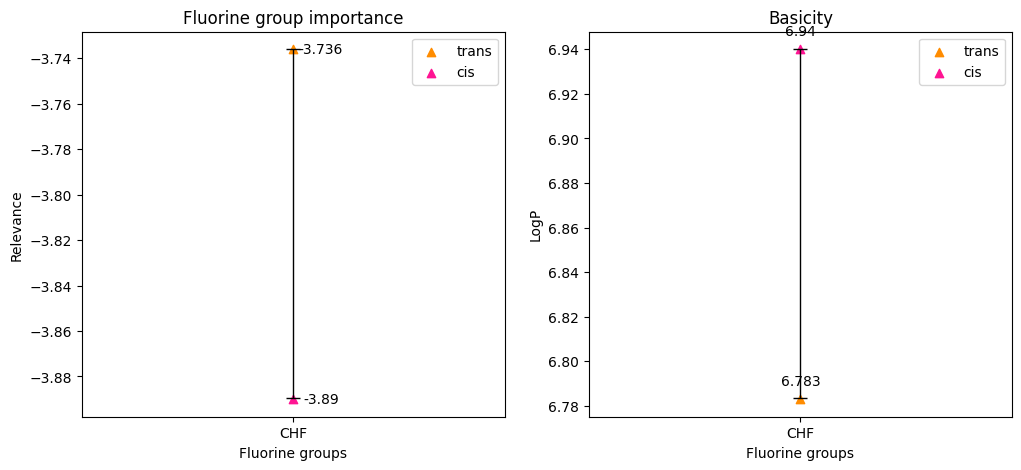

[] []
[] []
[] []


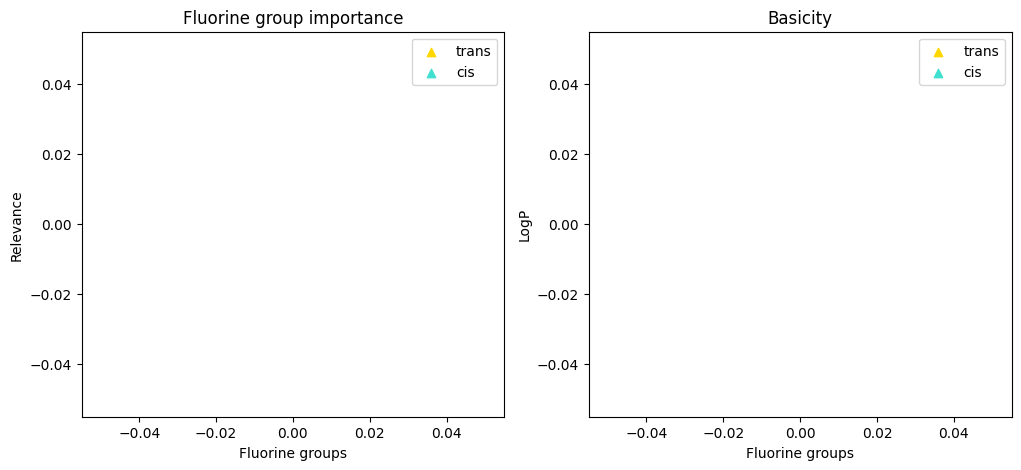

[] []
[] []
[] []


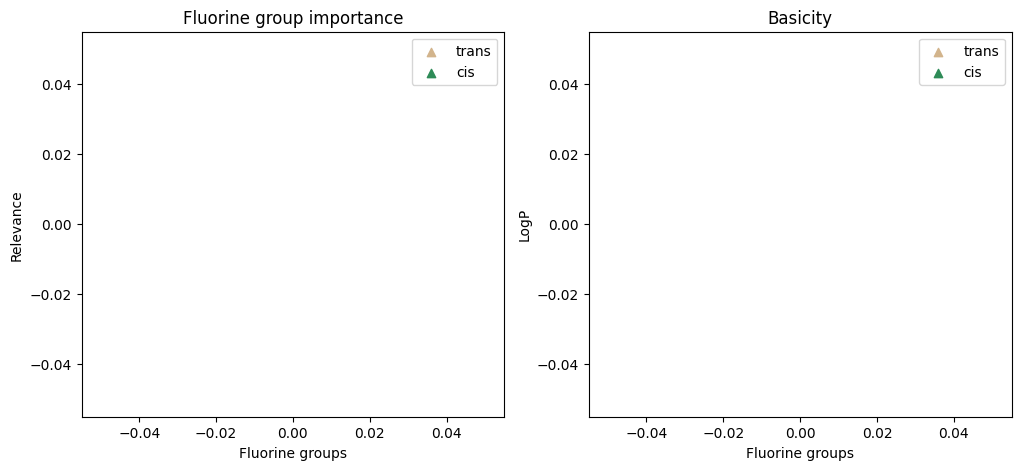

In [135]:
import matplotlib.pyplot as plt
import numpy as np

cis_color = {1: 'indigo', 2: 'deeppink', 3: 'turquoise', 4: 'seagreen'}
trans_color = {1: 'plum', 2: 'darkorange', 3: 'gold', 4: 'tan'}

cis_name = 'cis'
trans_name = 'trans'

cis = {1: {}, 2: {}, 3: {}, 4: {}}
trans = {1: {}, 2: {}, 3: {}, 4: {}}

cis_logP = {1: {}, 2: {}, 3: {}, 4: {}}
trans_logP = {1: {}, 2: {}, 3: {}, 4: {}}

for distance_global in range(2, 5):
    
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 5))
    
    X_optimal = ['CHF', 'CH2F', 'gem-CF2', 'CHF2', 'CF3']
    for SMILES, distance in smiles_to_distance_to_nitrogen.items():
        logP_value = SMILES_to_pKa[SMILES]
    
        if distance != distance_global:
            continue
        
        
        if 'cis' in smiles_to_id[SMILES]:
            f_group = SMILES_to_fgroup[SMILES]
            if f_group in cis[distance_global]:
                cis[distance_global][f_group].append(SME_fluorine[SMILES])
                cis_logP[distance_global][f_group].append(SMILES_to_pKa[SMILES])
            else:
                cis[distance_global][f_group] = [SME_fluorine[SMILES]]
                cis_logP[distance_global][f_group] = [SMILES_to_pKa[SMILES]]
            print("cis", f_group, SMILES, logP_value, SME_fluorine[SMILES], SMILES_to_identificator[SMILES])

        elif 'trans' in smiles_to_id[SMILES]:
            
            f_group = SMILES_to_fgroup[SMILES]
            if f_group in trans[distance_global]:
                trans[distance_global][f_group].append(SME_fluorine[SMILES])
                trans_logP[distance_global][f_group].append(SMILES_to_pKa[SMILES])
            else:
                trans[distance_global][f_group] = [SME_fluorine[SMILES]]
                trans_logP[distance_global][f_group] = [SMILES_to_pKa[SMILES]]
            print("trans", f_group, SMILES, logP_value, SME_fluorine[SMILES], SMILES_to_identificator[SMILES])


    # print(cis)
    X, Y, Y_logP = [], [], []
    Y_dict = {f_group: [] for f_group in X_optimal}
    Y_logP_dict = {f_group: [] for f_group in X_optimal}
    for molecule_group, color, label, logP_dict in [
        (trans, trans_color, trans_name, trans_logP),
        (cis, cis_color, cis_name, cis_logP), 
    ]:
        y_relevance, y_logP, X_local = [], [], []
        if distance_global not in molecule_group:
            continue

        for f_group_optimal in X_optimal:
            if f_group_optimal not in molecule_group[distance_global]:
                continue
            X_local.append(f_group_optimal)

            
            

            Y_dict[f_group_optimal].append(sum(molecule_group[distance_global][f_group_optimal]) / len(molecule_group[distance_global][f_group_optimal]))
            y_relevance.append(round(sum(molecule_group[distance_global][f_group_optimal]) / len(molecule_group[distance_global][f_group_optimal]), 3))
            Y_logP_dict[f_group_optimal].append(sum(logP_dict[distance_global][f_group_optimal]) / len(logP_dict[distance_global][f_group_optimal]))
            y_logP.append(round(sum(logP_dict[distance_global][f_group_optimal]) / len(logP_dict[distance_global][f_group_optimal]), 3))

        print(X_local, y_relevance)
        ax1.scatter(X_local, y_relevance, marker='^', linestyle='-', color=color[distance_global], label=label)
        for i in range(len(X_local)):
            ax1.annotate(f"{str(y_relevance[i])}", (X_local[i], y_relevance[i]), xytext=(20, -3), textcoords='offset points', ha='center')
        ax1.legend()

        ax2.scatter(X_local, y_logP, marker='^', linestyle='-', color=color[distance_global], label=label)
        for i in range(len(X_local)):
            ax2.annotate(f"{str(y_logP[i])}", (X_local[i], y_logP[i]), xytext=(0, 10), textcoords='offset points', ha='center')
        ax2.legend()
    
    
    for f_group_name, relevances in Y_dict.items():
        if relevances != []:
            X.append(f_group_name)
            Y.append(relevances)
            Y_logP.append(Y_logP_dict[f_group_name])
    
    print(X, Y)
    mean_Y = [np.array(i).mean() for i in Y]
    std_deviation_Y = [np.array(i).std() for i in Y]
    
    ax1.plot(X, mean_Y, linestyle='-', color="black", label=label, linewidth=1)
    for i in range(len(X)):
        ax1.errorbar(X[i], mean_Y[i], yerr=std_deviation_Y[i], color='black', capsize=5, elinewidth=1, markeredgewidth=1)
    ax1.set_xlabel("Fluorine groups")
    ax1.set_ylabel("Relevance")
    ax1.set_title("Fluorine group importance")

    mean_logP_Y = [np.array(i).mean() for i in Y_logP]
    std_deviation_logP_Y = [np.array(i).std() for i in Y_logP]
    
    ax2.plot(X, mean_logP_Y, linestyle='-', color="black", label=label, linewidth=1)
    for i in range(len(X)):
        ax2.errorbar(X[i], mean_logP_Y[i], yerr=std_deviation_logP_Y[i], color='black', capsize=5, elinewidth=1, markeredgewidth=1)
    ax2.set_xlabel("Fluorine groups")
    ax2.set_ylabel("LogP")
    ax2.set_title("Basicity")

    plt.show()
    
    


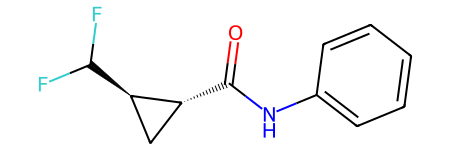

In [136]:
from rdkit import Chem

smi = "[H]C(F)(F)[C@@H]1C[C@H]1C(=O)NC1=CC=CC=C1"
canon_smi = Chem.CanonSmiles(smi)

Chem.MolFromSmiles(canon_smi)

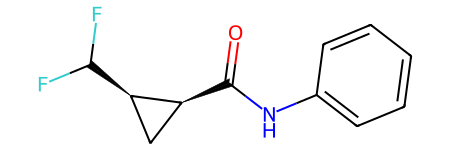

In [137]:
from rdkit import Chem

smi = "[H]C(F)(F)[C@@H]1C[C@@H]1C(=O)NC1=CC=CC=C1"
canon_smi = Chem.CanonSmiles(smi)

Chem.MolFromSmiles(canon_smi)